In [20]:
import pandas as pd
import numpy as np
import sklearn

In [6]:
col_names = ['degree', 'university', 'letter', 'experience', 'hire']
data = pd.read_csv('university.csv', skiprows=1, header= None, names=col_names)
data.head(12)

,degree,university,letter,experience,hire
1,FIRST,MKU,GOOD,YES,Y
2,SECOND,MKU,GOOD,NO,Y
3,FIRST,TUK,GOOD,YES,Y
4,PASS,TUK,BAD,YES,N
5,SECOND,ZETECH,BAD,YES,N
6,FIRST,ZETECH,GOOD,NO,N
7,PASS,UON,BAD,NO,Y
8,SECOND,UON,GOOD,NO,Y
9,PASS,KCA,BAD,YES,N
10,FIRST,KCA,BAD,YES,Y


In [23]:
import numpy as np

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, info_gain=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.info_gain = info_gain

class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=2):
        '''constructor'''

        # initialize the root of the tree
        self.root = None

        # stopping condition
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        '''recursive function to build the tree'''

        x, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(x)

        # split until stopping conditions are met
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"] > 0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                # return decision node
                return Node(
                    best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree,
                    info_gain=best_split["info_gain"]
                )

        # compute leaf node
        leaf_value = self.calculate_leaf_value(y)
        # return leaf node
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        '''function to find the best split'''

        # dictionary to store the best split
        best_split = {}
        max_info_gain = float("-inf")

        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if children are not null
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gain")
                    # update the best split if needed
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        # return best split
        return best_split

    def split(self, dataset, feature_index, threshold):
        '''function to split the data'''

        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, node="entropy"):
        '''function to compute information gain'''

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if node == "gain":
            gain = weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child)
        else:
            gain = weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child)
        return gain

    def entropy(self, y):
        '''function to compute entropy'''

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        '''function to compute gini index'''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        '''function to compute leaf node'''

        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        '''function to print the tree'''

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print("X_" + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        '''function to train the tree'''

        dataset = np.concatenate((X, Y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        '''function to predict new dataset'''

        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        '''function to predict new dataset'''

        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


## X = data.iloc[:, :-1].values
Y = data.iloc[:, :-1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_test=42)

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels, respectively
X = np.array([[1, 2], [3, 4], [5, 6]])  # Your feature data
y = np.array([0, 1, 0])  # Your label data

# Assuming X and y are your features and labels, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy
print('X')
print('y')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


X
y
Accuracy: 0.00%


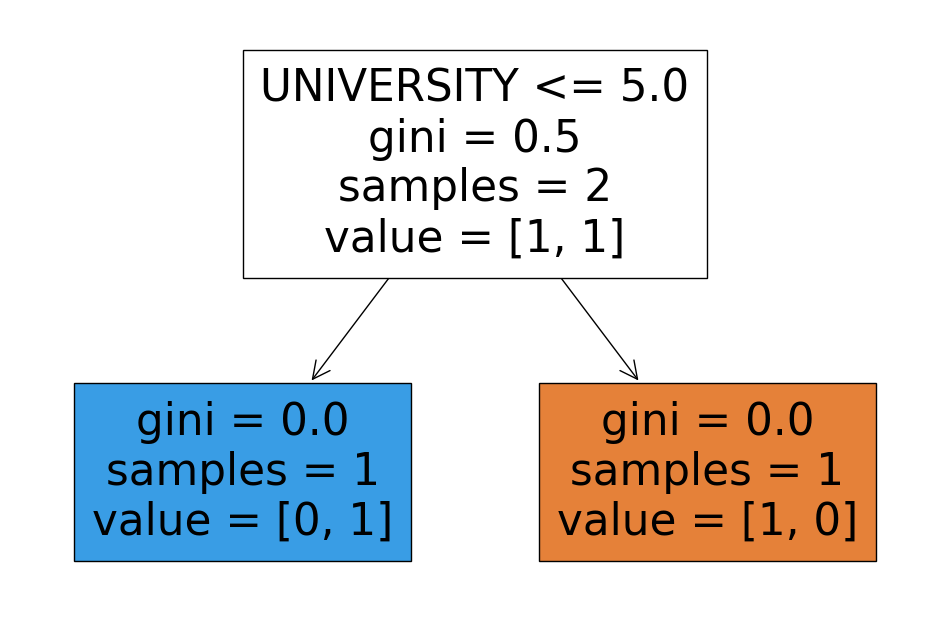

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Import plot_tree here
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Your other import statements and code...

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)


plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=['DEGREE', 'UNIVERSITY', 'LETTER', 'EXPERIENCE'])
plt.show()